In [1]:
%matplotlib inline
import pylab
import seaborn as sns
import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import sys

### Relative Performance

In [2]:
import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

# pickle file containing neural model results
fname = "neural_predictions.p"
data = pickle.load(open(fname, 'rb'))

node_predictions = []
obs_age = []
for key, value in data.items():
    obs_age.append(key)
    node_predictions.append(value[1])

In [3]:
# Human data obtained from from Griffiths and Tenenbaum (2006)
x_h = [16.966846103536767, 37.99333101079978, 60.59075299855671, 82.05096302194794, 95.0629572487931]
y_h = [73.34244604316546, 73.59154929577466, 76.05633802816902, 89.43661971830986, 98.23943661971833]


# Data from Bayesian model by Griffiths and Tenenbaum (2006)
x_tm = [2.83687943262413, 
        16.66666666666667, 
        29.078014184397162, 
        38.29787234042554,
        49.29078014184395,
        59.57446808510639, 
        73.40425531914894, 
        82.9787234042553, 
        96.09929078014184] 
       
y_tm = [76.07142857142856,
        77.50000000000003,
        77.50000000000003,
        78.57142857142858,
        79.28571428571428,
        81.42857142857144,
        84.28571428571428,
        89.28571428571428,
        98.57142857142858]       

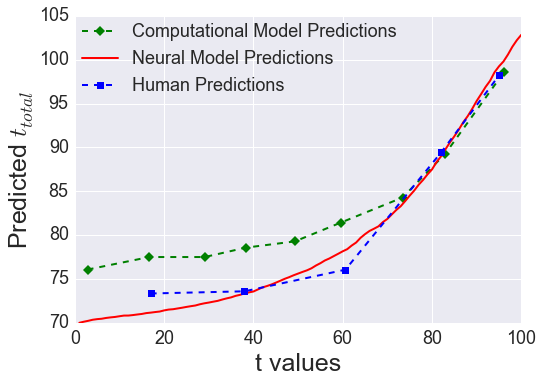

In [15]:
sns.set_style('darkgrid')
tenenbaum_model = plt.plot(x_tm, y_tm, 'gD--', linewidth=2.0, label="Computational Model Predictions")
nengo_model = plt.plot(obs_age, node_predictions, 'r', linewidth=2.0, label="Neural Model Predictions")
human = plt.plot(x_h, y_h, 'bs--', linewidth=2.0, label="Human Predictions")
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., fontsize=18)
plt.savefig('model_predictions.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Kolmogorov-Smirnov (K-S) 

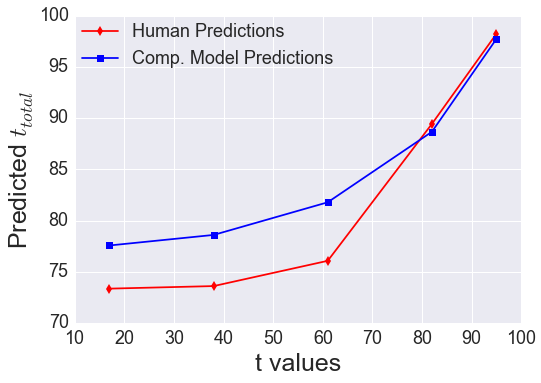

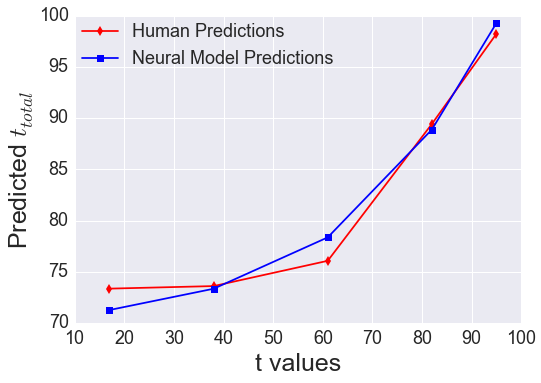

In [5]:
# Kolmogorov-Smirnov (K-S) test plots

x = [17, 38, 61, 82, 95]
y_human = [73.34, 73.59, 76.06, 89.44, 98.24]
y_comp = [77.56, 78.59, 81.78, 88.67, 97.74]
y_neural = [71.25, 73.33, 78.35, 88.89, 99.29]

plt.figure()
plt.plot(x, y_human, 'rd-', label = "Human Predictions")
plt.plot(x, y_comp, 'bs-', label = "Comp. Model Predictions")
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., fontsize=18)
plt.savefig('kolmogrov_comp.pdf', bbox_inches='tight', dpi=300)


plt.figure()
plt.plot(x, y_human, 'rd-', label = "Human Predictions")
plt.plot(x, y_neural, 'bs-', label = "Neural Model Predictions")
plt.xlabel("t values", fontsize=25)
plt.ylabel("Predicted $t_{total}$", fontsize=25)
plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., fontsize=18)
plt.savefig('kolmogrov_neural.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# Data from Bayesian model by Griffiths and Tenenbaum (2006)
2.83687943262413, 76.07142857142856
16.66666666666667, 77.50000000000003
29.078014184397162, 77.50000000000003
38.29787234042554, 78.57142857142858
49.29078014184395, 79.28571428571428
59.57446808510639, 81.42857142857144
73.40425531914894, 84.28571428571428
82.9787234042553, 89.28571428571428
96.09929078014184, 98.57142857142858
103.54609929078012, 105

In [ ]:
# Human data obtained from from Griffiths and Tenenbaum (2006)
# 5 median points
16.966846103536767, 73.34244604316546
37.99333101079978, 73.59154929577466
60.59075299855671, 76.05633802816902
82.05096302194794, 89.43661971830986
95.0629572487931, 98.23943661971833

# 5 corresponding points - Bayesian model by Griffiths and Tenenbaum (2006)
95.09803921568627, 97.73605383112655
82.02614379084969, 88.67303378916142
60.67538126361655, 81.77785013144249
37.908496732026144, 78.59272122132987
16.993464052287578, 77.5642138774329

# 5 corresponding points - Neural Model
95.09803921568627, 99.28586932928154
82.02614379084969, 88.89443600318356
60.566448801742915, 78.3462364035405
37.7995642701525, 73.33453922774522
16.884531590413943, 71.2543713672431